# Speech Command Recognition 

## Import needed modules

In [1]:
import tensorflow as tf
import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import SpeechDownloader
import AudioGen
import speech_model


## Download data from google speech command dataset

In [2]:
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task='35word')

0it [00:00, ?it/s]
0it [00:00, ?it/s]

Google Speech commands dataset version 2 already exists. Skipping download.
Converting test set WAVs to numpy files
Converting training set WAVs to numpy files


Done preparing Google Speech commands dataset version 2


# Audio Generator

In [3]:
#the default sampling rate for google speech command dataset
sr = 16000
iLen = sr
#We have four sets of dataset: train/val/test/testReal, in which train/val/test are used for training process
#and testReal is used for testing.

#As a result, we need to define 4 generator respectively for each set of data.
trainGen = AudioGen.AudioGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
valGen   = AudioGen.AudioGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)
testGen  = AudioGen.AudioGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = AudioGen.AudioGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))

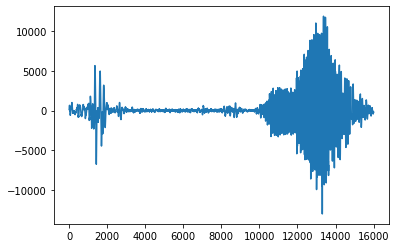

In [4]:
#The __getitem__ method in AudioGen is used to get a batch(32) of data
#The following code is used for check whether the generator works fine
audios_train, classes_train = trainGen.__getitem__(10)
audios_test, classes_test = testGen.__getitem__(15)
classes_train
plt.plot(audios_train[5])

In [5]:
#Before we define our model, we need to test whether our pre-processing of audios works fine.
#To test it, we create a model with keras with two simple layers: 
#One melspectrogram layer and one normalization2D layer. 

from tensorflow.keras.models import Sequential
from spela.melspectrogram import Melspectrogram
from spela.normalisation import Normalization2D
import numpy as np
import soundfile as sf
from scipy.fftpack import dct
import math
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Lambda
import tensorflow.keras.layers

melspecModel = Sequential()
melspecModel.add(Melspectrogram(n_dft=512, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )
melspecModel.add(Normalization2D(int_axis=0))
melspecModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        283728    
_________________________________________________________________
normalization2d (Normalizati (None, 80, 125, 1)        0         
Total params: 283,728
Trainable params: 283,728
Non-trainable params: 0
_________________________________________________________________


In [6]:
melspec = melspecModel.predict(audios_train.reshape((-1,1,iLen)) )
melspec.shape

(32, 80, 125, 1)

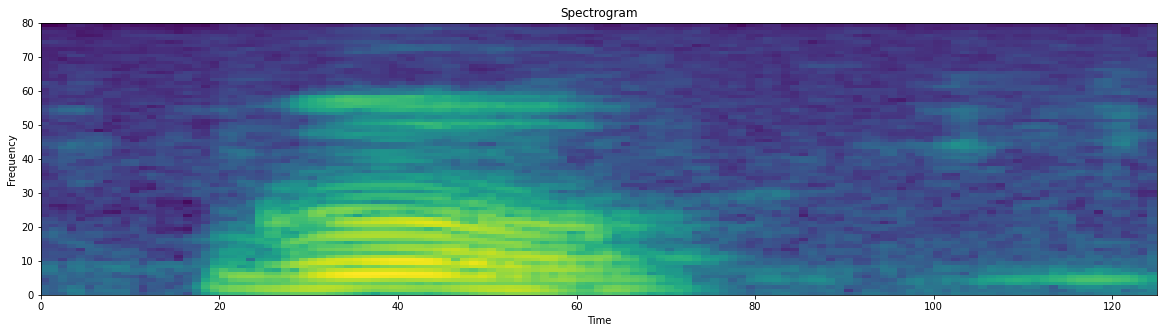

In [7]:
plt.figure(figsize=(20,5))
plt.pcolormesh(melspec[4,:,:,0])

plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.show()

# Models

In [23]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from adjust_utils import *

In [24]:
model_p1 = speech_model.att_rnn_model(nCategs, samplingrate = sr, inputLength = None)
model_p1.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model_p1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
Mel_Spec (Melspectrogram)       (None, 80, None, 1)  1091664     reshape_2[0][0]                  
__________________________________________________________________________________________________
Mel_Spec_Norm (Normalization2D) (None, 80, None, 1)  0           Mel_Spec[0][0]                   
____________________________________________________________________________________________

In [25]:
model_p1.load_weights('model_attRNN_p1.h5')

In [26]:
lr_power_1 = LearningRateScheduler(power_decay_1)

earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1, restore_best_weights=True)

cp_p1 = ModelCheckpoint(filepath='model_attRNN_p1.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)
results_p1 = model_p1.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, cp_p1, lr_power_1])

model_p1.save('model_attRNN_p1.h5')

Changing learning rate to 0.001
Epoch 1/60

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.94926, saving model to model_attRNN_p1.h5
3313/3313 - 506s - loss: 0.0800 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.2143 - val_sparse_categorical_accuracy: 0.9493 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/60

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.94926
3313/3313 - 506s - loss: 0.0942 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.2452 - val_sparse_categorical_accuracy: 0.9425 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/60

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.94926
3313/3313 - 510s - loss: 0.0738 - sparse_categorical_accuracy: 0.9799 - val_loss: 0.2429 - val_sparse_categorical_accuracy: 0.9467 - lr: 0.0010
Changing learning rate to 0.001
Epoch 4/60

Epoch 00004: val_sparse_categorical_accuracy did not improve from 0.94926
3313/3313 - 509s - loss: 0.0726 - sparse_categorical_accura

In [14]:
model_p2 = speech_model.att_rnn_model(nCategs, samplingrate = sr, inputLength = None)
model_p2.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model_p2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
Mel_Spec (Melspectrogram)       (None, 80, None, 1)  1091664     reshape[0][0]                    
__________________________________________________________________________________________________
Mel_Spec_Norm (Normalization2D) (None, 80, None, 1)  0           Mel_Spec[0][0]                   
______________________________________________________________________________________________

In [15]:
model_e = speech_model.att_rnn_model(nCategs, samplingrate = sr, inputLength = None)
model_e.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model_e.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
Mel_Spec (Melspectrogram)       (None, 80, None, 1)  1091664     reshape[0][0]                    
__________________________________________________________________________________________________
Mel_Spec_Norm (Normalization2D) (None, 80, None, 1)  0           Mel_Spec[0][0]                   
______________________________________________________________________________________________

In [17]:
model_m = speech_model.att_rnn_model(nCategs, samplingrate = sr, inputLength = None)
model_m.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model_m.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
Mel_Spec (Melspectrogram)       (None, 80, None, 1)  1091664     reshape_1[0][0]                  
__________________________________________________________________________________________________
Mel_Spec_Norm (Normalization2D) (None, 80, None, 1)  0           Mel_Spec[0][0]                   
____________________________________________________________________________________________

In [21]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

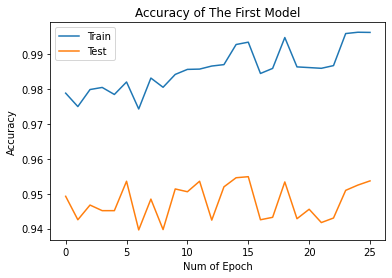

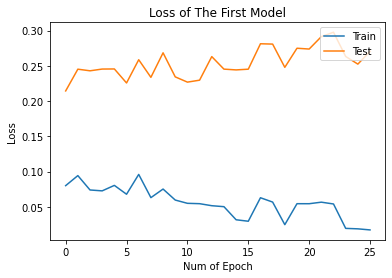

In [46]:
# summarize history for categorical accuracy
plt.plot(results_p1.history['sparse_categorical_accuracy'])
plt.plot(results_p1.history['val_sparse_categorical_accuracy'])
plt.title('Accuracy of The First Model')
plt.ylabel('Accuracy')
plt.xlabel('Num of Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results_p1.history['loss'])
plt.plot(results_p1.history['val_loss'])
plt.title('Loss of The First Model')
plt.ylabel('Loss')
plt.xlabel('Num of Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


In [28]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [30]:
valEval = model_p1.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model_p1.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model_p1.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model_p1.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.0810353010892868, 0.9803991913795471] 
Validation: [0.28721341490745544, 0.9434284567832947] 
Test: [0.22558599710464478, 0.9534757137298584]


In [31]:
kaggle12cmd = False
if kaggle12cmd:
    #only for the Kaggle competition, 12-cmd
    x_testR, y_testR = testRGen.__getitem__(0)
    testREval = model.evaluate(x_testR, y_testR, verbose=1)
    print(testREval)
    testREval = model.evaluate(testRGen, use_multiprocessing=True, workers=4,verbose=1)
    print(testREval)

## Evaluation and Attention Plots

In [33]:
from tensorflow.keras.models import Model, load_model
attSpeechModel_p1 = Model(inputs=model_p1.input, outputs=[model_p1.get_layer('output').output, model_p1.get_layer('Att_weighted_Softmax').output, model_p1.get_layer('Mel_Spec').output])


In [34]:
audios, classes = valGen.__getitem__(3)
classes

array([ 4,  3, 21, 10, 13, 13,  2,  8, 24, 11, 11, 26, 15, 33, 19, 17, 25,
       18, 21,  4,  9,  2, 11,  1,  3, 31, 18, 12, 10, 15, 16,  9])

In [35]:
idAudio = 8
classes[idAudio]

24

In [38]:
outs, attW, specs = attSpeechModel_p1.predict(audios)

In [39]:
np.argmax(outs,axis=1)

array([ 4,  3, 21, 10, 13, 13,  2,  8,  4, 11, 11, 26, 15, 33, 19, 17, 25,
       18, 21,  4,  9,  2, 11,  3,  3, 31, 18, 12, 10, 15, 16, 30])

In [40]:
specs.shape

(32, 80, 125, 1)

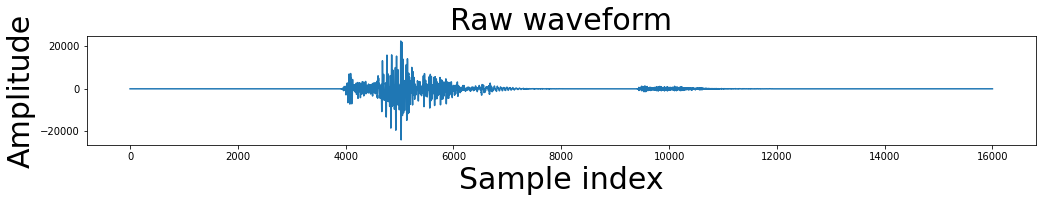

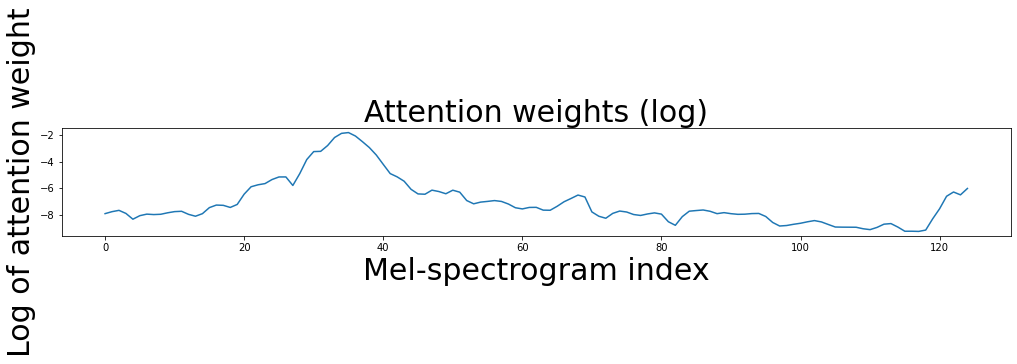

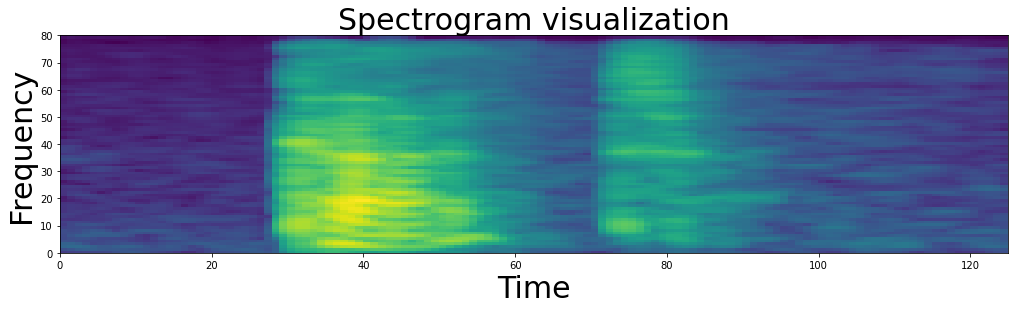

In [41]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [42]:
y_pred = model_p1.predict(x_test, verbose=1)

344/344 [==============================] - 23s 68ms/step


In [43]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [44]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

No Normalization


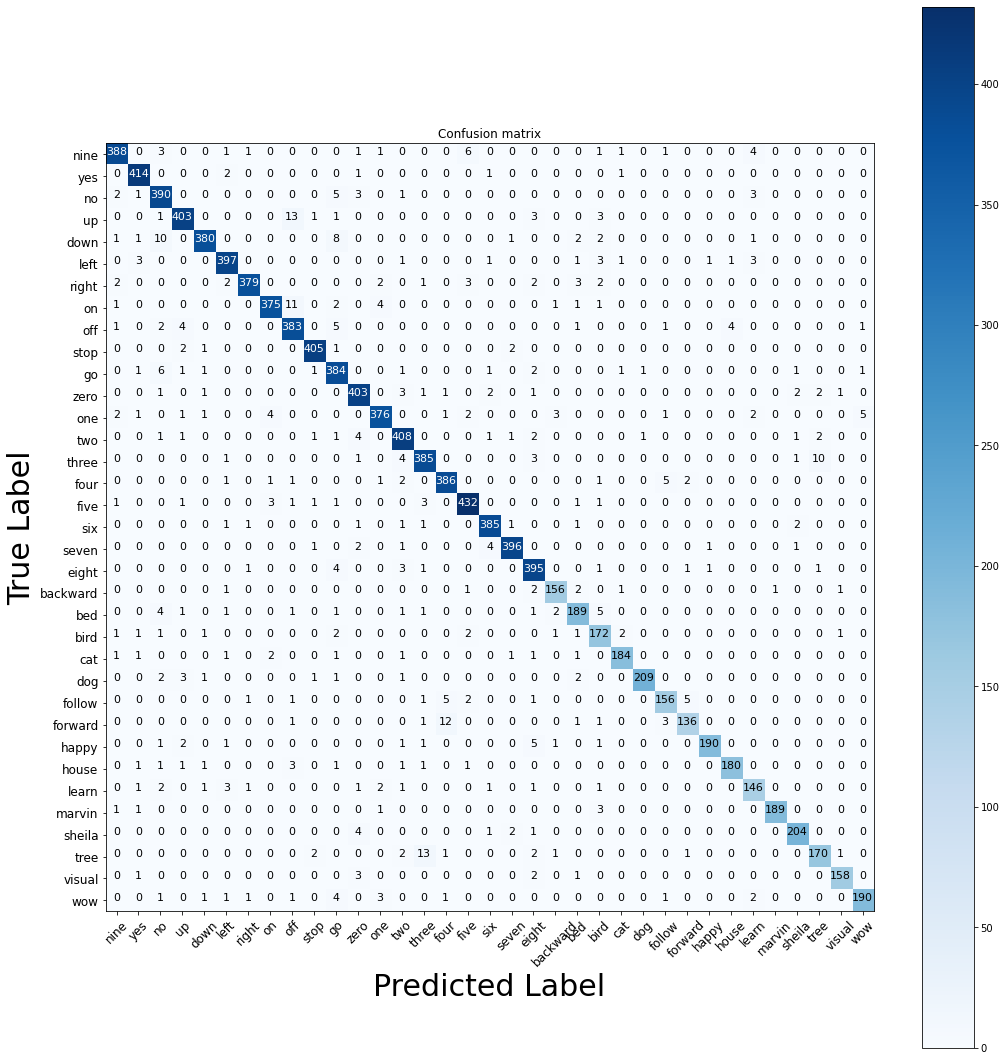

In [45]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)